### LAB 1 Flower recognition 

In [2]:
!rm -rf '/content/flowers'
!rm flowers-new.zip

In [3]:
#IMPORTING
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import tensorflow as tf
from keras import backend as K
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [4]:
#IMPORTING DATASET
#Getting the dataset
!wget http://upscfever.com/datasets/flowers-new.zip
#Unzipping the dataset
!unzip -q flowers-new.zip #-q is specified to remove the info displayed for each image

--2020-12-06 20:56:59--  http://upscfever.com/datasets/flowers-new.zip
Resolving upscfever.com (upscfever.com)... 104.27.177.133, 104.27.176.133, 172.67.193.2, ...
Connecting to upscfever.com (upscfever.com)|104.27.177.133|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/flowers-new.zip [following]
--2020-12-06 20:56:59--  https://upscfever.com/datasets/flowers-new.zip
Connecting to upscfever.com (upscfever.com)|104.27.177.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘flowers-new.zip’

flowers-new.zip         [         <=>        ]   5.74M  2.20MB/s    in 2.6s    

2020-12-06 20:57:03 (2.20 MB/s) - ‘flowers-new.zip’ saved [6021364]



In [5]:
#COMPILING DATA
#Defining a function to generate more data with slight variations for training
def gen_data(flower):
  label = flower
  path = '/content/flowers/' + flower
  img_list = os.listdir(path)
  for img in img_list:
    img = cv2.imread(path + '/' + img)
    img = img.reshape((1,) + img.shape) 

    augment = ImageDataGenerator(rescale = 1./255, zoom_range = 0.1, 
                             height_shift_range = 0.1, shear_range = 5, rotation_range = 5,
                             horizontal_flip = True)

    i = 0
    for batch in augment.flow(img, batch_size = 1, save_to_dir = path + '/', save_prefix = 'gen', 
                        save_format = 'jpeg'):
      i = i+1
      if i == 20: break

In [6]:
#Defining a function to compile our dataset since our data is in different folders
x = []
y = []
def compile_data(flower):
  label = flower
  path = '/content/flowers/' + flower
  img_list = os.listdir(path)
  for img in img_list:
    img = cv2.imread(path + '/' + img)
    img = cv2.resize(img, (256, 256))
    x.append(img)
    y.append(label)


In [7]:
#Generating more data for each flower
gen_data('daisy')
gen_data('dandelion')
gen_data('rose')
gen_data('sunflower')
gen_data('tulip')

In [8]:
#Compiling all the data
compile_data('daisy')
compile_data('dandelion')
compile_data('rose')
compile_data('sunflower')
compile_data('tulip')

In [9]:
print(len(x), len(y))

2412 2412


In [10]:
#Converting all the images into NumPy Array, Reshaping then Scaling
x = np.array(x)
x = np.reshape(x, (len(x), 256*256*3))
x = x/255
np.shape(x)

(2412, 196608)

In [11]:
#Converting all the flowers into labels
LE = LabelEncoder()
y = LE.fit_transform(y)
y = to_categorical(y)
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

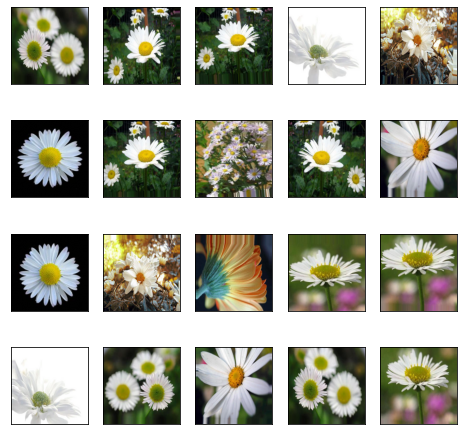

In [12]:
#Checking images
fig = plt.figure(figsize = (8, 8))
for i in range(20):
    ax = fig.add_subplot(4,5, i + 1, xticks=[], yticks=[])
    ax.imshow(x[i].reshape(256, 256, 3), cmap=plt.cm.bone)

In [13]:
#Splitting into Train-Test Sets and Setting random seeds
seed = 1
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Building NN MODEL

In [14]:
nn = models.Sequential()
nn.add(layers.Dense(512, activation = 'relu', input_shape = (256*256*3,)))
nn.add(layers.Dense(256, activation = 'relu'))
nn.add(layers.Dense(128, activation = 'relu'))
nn.add(layers.Dense(5, activation = 'softmax'))
nn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [15]:
#Preparing data for CNN
x = np.reshape(x, (np.shape(x)[0], 256, 256, 3))

In [16]:
#Splitting into Train-Test Sets and Setting random seeds
seed = 3
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
x_train.shape

(1929, 256, 256, 3)

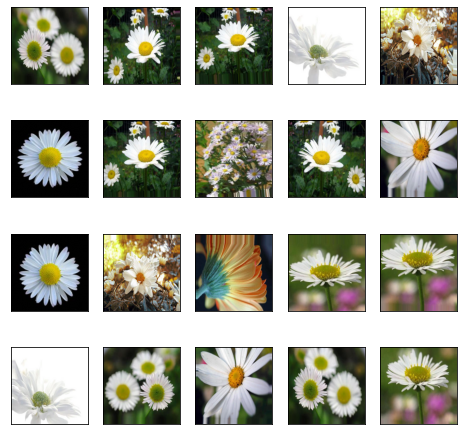

In [18]:
#Checking the Images
fig = plt.figure(figsize = (8, 8))
for i in range(20):
  ax = fig.add_subplot(4, 5, i + 1, xticks = [], yticks = [])
  ax.imshow(x[i], cmap = plt.cm.bone)

Building CNN MODEL

In [19]:
from keras.models import Input, Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU

In [20]:
cnn = Sequential()
cnn.add(Conv2D(32, kernel_size = (3, 3), activation = 'linear', input_shape = (256, 256, 3), padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPool2D((2,2), padding = 'same'))
cnn.add(Dropout(0.1))
cnn.add(Conv2D(64, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPool2D((2,2), padding = 'same'))
cnn.add(Dropout(0.1))
cnn.add(Conv2D(128, (3, 3), activation = 'linear', padding = 'same'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(MaxPool2D((2, 2), padding = 'same'))
cnn.add(Dropout(0.1))
cnn.add(Flatten())
cnn.add(Dense(128, activation = 'linear'))
cnn.add(LeakyReLU(alpha = 0.1))
cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation = 'softmax'))
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)       

In [22]:
#Fitting to Training Data
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.05, patience = 10, mode = 'max', restore_best_weights = True)
sm= tf.keras.callbacks.ModelCheckpoint(filepath= "best.hdf5", save_weights_only= True, monitor= 'val_accuracy',mode= 'max', save_best_only= True)
history = cnn.fit(x_train, y_train, epochs = 25, validation_split = 0.25, callbacks = [es, sm])

Epoch 1/25
46/46 [==============================] - 6s 135ms/step - loss: 1.7785 - accuracy: 0.5118 - val_loss: 0.7632 - val_accuracy: 0.7205
Epoch 2/25
46/46 [==============================] - 5s 118ms/step - loss: 0.6172 - accuracy: 0.7739 - val_loss: 0.5154 - val_accuracy: 0.8261
Epoch 3/25
46/46 [==============================] - 5s 117ms/step - loss: 0.3706 - accuracy: 0.8721 - val_loss: 0.5203 - val_accuracy: 0.8364
Epoch 4/25
46/46 [==============================] - 5s 118ms/step - loss: 0.1915 - accuracy: 0.9378 - val_loss: 0.2263 - val_accuracy: 0.9089
Epoch 5/25
46/46 [==============================] - 5s 118ms/step - loss: 0.2008 - accuracy: 0.9433 - val_loss: 0.1903 - val_accuracy: 0.9296
Epoch 6/25
46/46 [==============================] - 5s 113ms/step - loss: 0.1341 - accuracy: 0.9557 - val_loss: 0.2191 - val_accuracy: 0.9213
Epoch 7/25
46/46 [==============================] - 5s 112ms/step - loss: 0.1170 - accuracy: 0.9647 - val_loss: 0.2343 - val_accuracy: 0.9255
Epoch 

In [23]:
cnn.evaluate(x_test, y_test)

16/16 [==============================] - 1s 38ms/step - loss: 0.1312 - accuracy: 0.9772


[0.13123191893100739, 0.977225661277771]

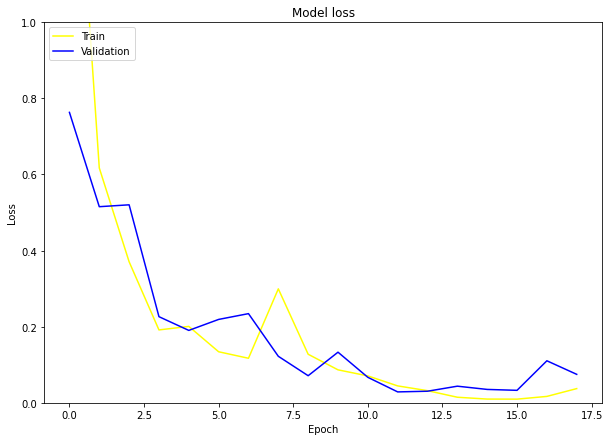

In [24]:
plt.figure(figsize = (10,7))
plt.plot(history.history['loss'], color = 'yellow')
plt.plot(history.history['val_loss'], color = 'blue')
plt.ylim((0,1))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()